In [0]:
# use following command to make colab connect google drive
#The maximum lifetime of a Colab VM is 12 hours.
!dpkg --configure -a
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive -o nonempty

In [0]:
#load the json data
import os
import json
data_path = '/content/drive/ColabWorkSpaces/INFO7374/Assignment3-Uncovering-Sentiments-using-EDGAR-Datasets/data/'
data_exist=os.path.exists(data_path)
labels = list()
document_list = list()
k=1
if data_exist:
  print('Data exist')
  file_names = os.listdir(data_path)
  for i in range(len(file_names)):
      print(file_names[i])
      file_path = data_path+file_names[i]
      print(file_path)
      with open(file_path,encoding="utf8", errors='ignore') as f:
        data = json.load(f)
        paragraphs = list()
        for item in data['text'].values():
          if len(item) < 524288:
            new_row = {'id': k, 'language': 'en', 'text':item}
            print(new_row)
            k = k+1
            paragraphs.append(new_row)
        documents = {'documents' :paragraphs}
        document_list.append(documents)
        for item in data['sentiment'].values():
          if item =="Neutral":
            labels.append(0)
          elif item == "Positive":
            labels.append(1)
          else:
            labels.append(-1)

In [0]:
# load the pickle data
import pickle
# obj = pickle.load(open("/content/drive/ColabWorkSpaces/INFO7374/Assignment3-Uncovering-Sentiments-using-EDGAR-Datasets/data/all_group_data.pickle", "rb"))
# print(obj)
k=0
num=1
labels=[]
document_list = list()
for i in range(0,3):
  paragraphs = list()
  for item in obj[k:k+644].values:
    labels.append(item[2])
    print(item[2])
    new_row = {'id': num, 'language': 'en', 'text':item[1]}
    num = num+1
    paragraphs.append(new_row)
#     print(new_row)
  k=k+644
  documents = {'documents' :paragraphs}
  document_list.append(documents)

neutral
neutral
negative
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
positive
neutral
neutral
neutral
neutral
neutral
positive
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
negative
neutral
positive
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
positive
neutral
neutral
neutral
negative
positive
negative
positive
neutral
neutral
positive
neutral
neutral
neutral
neutral
positive
neutral
neutral
neut

In [0]:
# use Microsoft text api to analyze sentiment
import requests
subscription_key = "04428434373c44de8e5d6a200d528415"
text_analytics_base_url = "https://westcentralus.api.cognitive.microsoft.com/text/analytics/v2.0/"
sentiment_api_url = text_analytics_base_url + "sentiment"
print(sentiment_api_url)

https://westcentralus.api.cognitive.microsoft.com/text/analytics/v2.0/sentiment


In [0]:
# document example
# documents = {'documents' : [
#   {'id': 1, 'language': 'en', 'text': 'Good afternoon, and welcome to Netflix Q4 2018 Earnings Interview. I’m Spencer Wang, VP of IR and Corporate Development. Joining me today are CEO, Reed Hastings; our new CFO, Spence Neumann; Chief Content Officer, Ted Sarandos; and our Chief Product Officer, Greg Peters. Our interviewer this quarter is Eric Sheridan from UBS. As a reminder, we will be making forward-looking statements and actual results may vary.'},
#   {'id': 2, 'language': 'en', 'text': 'With that, let me turn it over to you, Eric, for the first question.'}
# ]}

In [0]:
import pandas as pd
score_list = list()
for item in document_list:
  headers   = {"Ocp-Apim-Subscription-Key": subscription_key}
  response  = requests.post(sentiment_api_url, headers=headers, json=item)
  sentiments = response.json()
  for item in sentiments['documents']:
    if item['score']== 0.5:
      score_list.append('neutral')
    elif item['score']>0.5:
      score_list.append('positive')
    else:
      score_list.append('negative')
      
#     print(item['score'])

df =  pd.DataFrame({'scores':score_list,'orginal_label':labels})
# file_name = "/content/drive/ColabWorkSpaces/INFO7374/Assignment3-Uncovering-Sentiments-using-EDGAR-Datasets/result/microsoft.pickle"
# pickle.dump(df, open(file_name, "wb"))


In [0]:
print(df)

     orginal_label    scores
0          neutral   neutral
1          neutral   neutral
2         negative   neutral
3          neutral   neutral
4          neutral   neutral
5          neutral   neutral
6          neutral   neutral
7          neutral  positive
8          neutral   neutral
9          neutral  positive
10         neutral  negative
11         neutral  positive
12         neutral   neutral
13        positive   neutral
14         neutral   neutral
15         neutral   neutral
16         neutral   neutral
17         neutral   neutral
18         neutral   neutral
19        positive   neutral
20         neutral   neutral
21         neutral   neutral
22         neutral   neutral
23         neutral   neutral
24         neutral   neutral
25         neutral   neutral
26         neutral   neutral
27         neutral   neutral
28         neutral   neutral
29         neutral  positive
...            ...       ...
1614       neutral  positive
1615       neutral  positive
1616       neu

Confusion matrix, without normalization
[[ 20  79  56]
 [ 45 466 324]
 [ 40 309 305]]


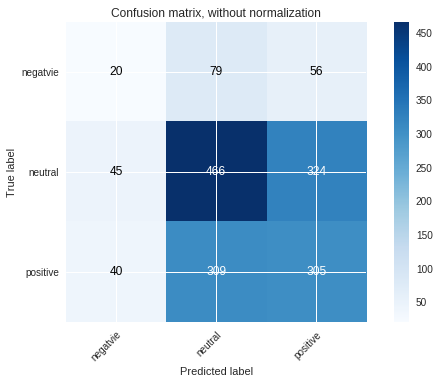

In [0]:
# calculate and print the confusion matrix
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


class_names = ['negatvie','neutral','positive']
# class_names = ['positive','neutral','negatvie']

# Plot non-normalized confusion matrix
plot_confusion_matrix(df['orginal_label'], df['scores'], classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
# plot_confusion_matrix(df['orginal_label'], df['scores'], classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

plt.show()
